In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from tqdm import tqdm

import mlflow

In [2]:

data = pd.read_csv('data.csv', index_col="Coden")
data.head()

/var/folders/11/31lkrfvs65ddtbwvncf1q57m0000gn/T/ipykernel_20799/627059569.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv', index_col="Coden")


,site.id,Crop.type,Treatment,Year.of.collection,Slope,Irrigation,Cropping.system.in.the.site,Rotational.systems,Name.of.previous.crop,Growing.days,...,Tmin10,PET10,PRE10,AI,USDA soil classification,Predicted.YGSOC,YGSOC.normalized,Yield.normalized.treatment,Yield.normalized,Yield
Coden,,,,,,,,,,,,,,,,,,,,,
1,1,Maize,N2P2K2,2010,2.0,No,2 times a year,Maize-wheat,Wheat,119,...,3.51,951.74,936.01,0.983475,NaN,14.92,0.0449,1.05,1.22,9005
2,1,Maize,N3P2K2,2010,2.0,No,2 times a year,Maize-wheat,Wheat,119,...,3.51,951.74,936.01,0.983475,NaN,14.79,0.0445,1.17,1.34,9839
3,1,Maize,N1P2K2,2010,2.0,No,2 times a year,Maize-wheat,Wheat,119,...,3.51,951.74,936.01,0.983475,NaN,22.55,0.0679,1.22,1.28,9394
4,1,Maize,N0P2K2,2010,2.0,No,2 times a year,Maize-wheat,Wheat,119,...,3.51,951.74,936.01,0.983475,NaN,19.12,0.0576,1.16,1.04,7671
5,1,Maize,Control,2010,2.0,No,2 times a year,Maize-wheat,Wheat,119,...,3.51,951.74,936.01,0.983475,NaN,30.56,0.0920,1.16,0.88,6503


In [3]:
# 数据分割函数
def prepare_data(df, crop_type: str, target_col='Yield'):
    if crop_type != 'threecrops':
        filtered = df[df['Crop.type'] == crop_type]
        cols = {
            'Maize': ["Yield", "Slope", "Irrigation", "Cropping.system.in.the.site", 
                     "Rotational.systems", "Name.of.previous.crop", "Growing.days", 
                     "GDD", "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP", 
                     "AK", "PH", "PK.fert", "N.fert", "SAND", "SILT", "CLAY", 
                     "AWC", "Bulk.density", "Crop.variety", "AI", "PET10"],
            'Wheat': ["Yield", "Slope", "Irrigation", "Cropping.system.in.the.site",
                     "Rotational.systems", "Name.of.previous.crop", "Growing.days",
                     "GDD", "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP",
                     "AK", "PH", "PK.fert", "N.fert", "SAND", "SILT", "CLAY",
                     "AWC", "Bulk.density", "Crop.variety", "AI", "PET10"],
            'Rice': ["Yield", "Slope", "Cropping.system.in.the.site", 
                    "Rotational.systems", "Growing.days", "GDD", "Tmax", "Tmin", 
                    "PRE", "RAD", "Soil.type", "SOC", "OP", "AK", "PH", "PK.fert", 
                    "N.fert", "SAND", "SILT", "CLAY", "AWC", "Bulk.density", 
                    "Crop.variety", "AI", "PET10"]
        }
        return filtered[cols[crop_type]]
    else:
        cols = ["Yield.normalized", "Slope", "Irrigation", "Cropping.system.in.the.site",
               "Rotational.systems", "Name.of.previous.crop", "Growing.days", "GDD",
               "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP", "AK", "PH",
               "PK.fert", "N.fert", "SAND", "SILT", "CLAY", "AWC", "Bulk.density",
               "Crop.variety", "AI", "PET10"]
        return df[cols]

# 准备数据
Maize = prepare_data(data, 'Maize')
Wheat = prepare_data(data, 'Wheat')
Rice = prepare_data(data, 'Rice')
threecrops = prepare_data(data, 'threecrops')


In [4]:
Maize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24107 entries, 1 to 24107
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Yield                        24107 non-null  int64  
 1   Slope                        24107 non-null  float64
 2   Irrigation                   24107 non-null  object 
 3   Cropping.system.in.the.site  24092 non-null  object 
 4   Rotational.systems           23662 non-null  object 
 5   Name.of.previous.crop        23590 non-null  object 
 6   Growing.days                 24107 non-null  int64  
 7   GDD                          24107 non-null  float64
 8   Tmax                         24107 non-null  float64
 9   Tmin                         24107 non-null  float64
 10  PRE                          24107 non-null  float64
 11  RAD                          24107 non-null  float64
 12  Soil.type                    24107 non-null  object 
 13  SOC                  

/var/folders/11/31lkrfvs65ddtbwvncf1q57m0000gn/T/ipykernel_20799/1226217646.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Maize['Yield'], color='g', bins=100, hist_kws={'alpha': 0.4})


count    24107.000000
mean      7504.113287
std       2142.970499
min        636.000000
25%       6029.000000
50%       7475.000000
75%       8940.000000
max      17430.000000
Name: Yield, dtype: float64


<Axes: xlabel='Yield', ylabel='Density'>

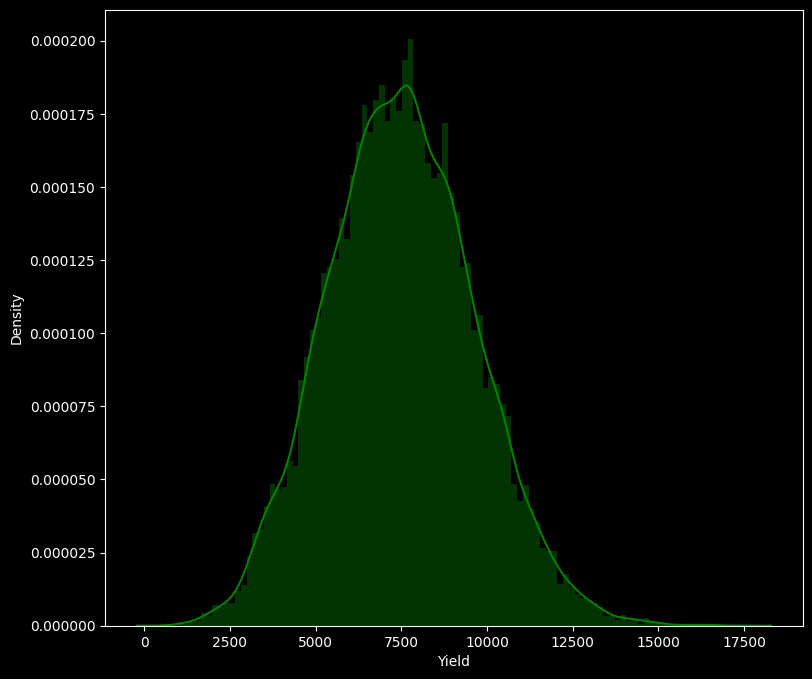

In [5]:
print(Maize['Yield'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(Maize['Yield'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [6]:
list(set(Maize.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [7]:
df_num = Maize.select_dtypes(include=['float64', 'int64'])
df_num.head()

,Yield,Slope,Growing.days,GDD,Tmax,Tmin,PRE,RAD,SOC,OP,...,PH,PK.fert,N.fert,SAND,SILT,CLAY,AWC,Bulk.density,AI,PET10
Coden,,,,,,,,,,,,,,,,,,,,,
1,9005,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,8.3,1,1.0,34,41,25,0.147,1.36,0.983475,951.74
2,9839,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,8.3,1,1.5,34,41,25,0.147,1.36,0.983475,951.74
3,9394,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,8.3,1,0.5,34,41,25,0.147,1.36,0.983475,951.74
4,7671,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,8.3,1,0.0,34,41,25,0.147,1.36,0.983475,951.74
5,6503,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,8.3,0,0.0,34,41,25,0.147,1.36,0.983475,951.74


In [8]:
df_obj = Maize.select_dtypes(include='object').columns.tolist()
df_obj

['Irrigation',
 'Cropping.system.in.the.site',
 'Rotational.systems',
 'Name.of.previous.crop',
 'Soil.type',
 'Crop.variety']

array([[<Axes: title={'center': 'Yield'}>,
        <Axes: title={'center': 'Slope'}>,
        <Axes: title={'center': 'Growing.days'}>,
        <Axes: title={'center': 'GDD'}>,
        <Axes: title={'center': 'Tmax'}>],
       [<Axes: title={'center': 'Tmin'}>,
        <Axes: title={'center': 'PRE'}>, <Axes: title={'center': 'RAD'}>,
        <Axes: title={'center': 'SOC'}>, <Axes: title={'center': 'OP'}>],
       [<Axes: title={'center': 'AK'}>, <Axes: title={'center': 'PH'}>,
        <Axes: title={'center': 'PK.fert'}>,
        <Axes: title={'center': 'N.fert'}>,
        <Axes: title={'center': 'SAND'}>],
       [<Axes: title={'center': 'SILT'}>,
        <Axes: title={'center': 'CLAY'}>,
        <Axes: title={'center': 'AWC'}>,
        <Axes: title={'center': 'Bulk.density'}>,
        <Axes: title={'center': 'AI'}>],
       [<Axes: title={'center': 'PET10'}>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

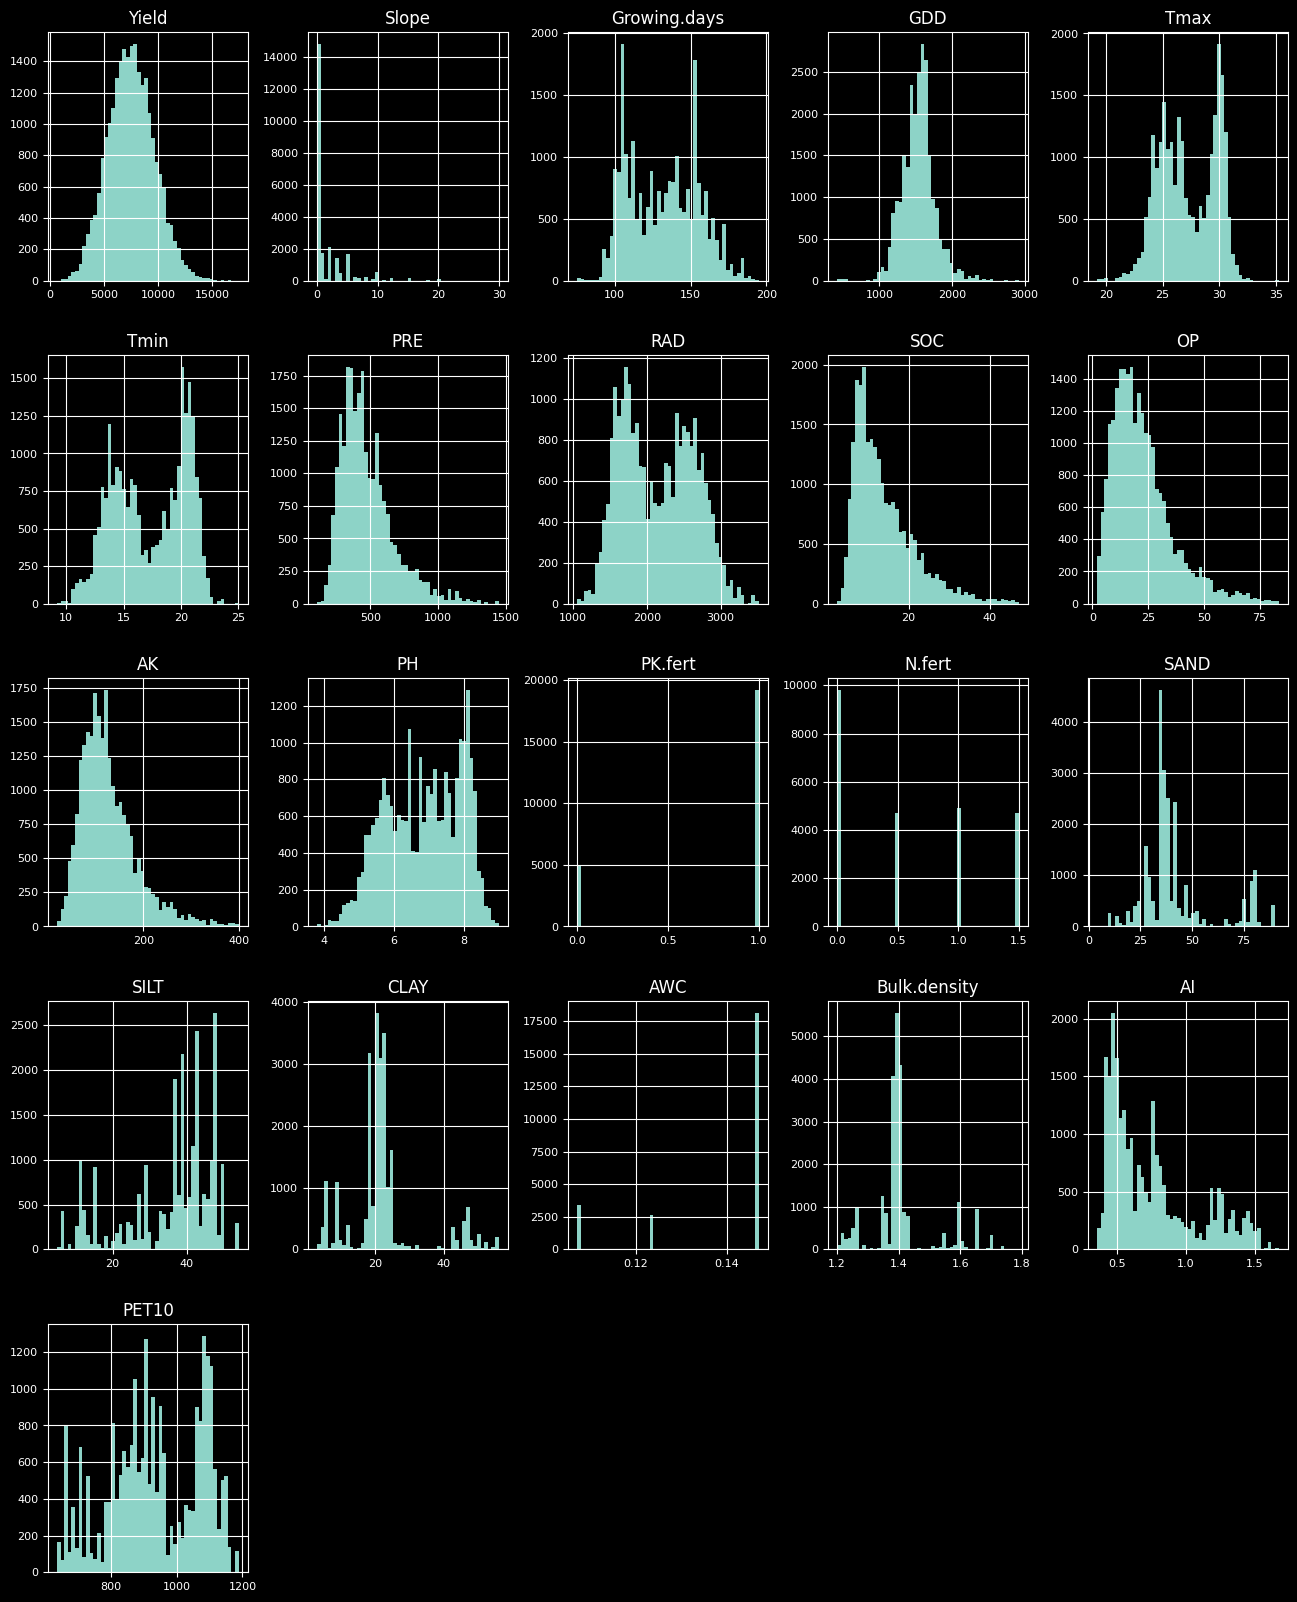

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [18]:
Maize.isna().any().any()

False

In [10]:
def data_prepare(name: pd.DataFrame):
    factor = name.select_dtypes(include='object').columns.tolist()
    for _ in factor:
        one_hot = pd.get_dummies(name[_], prefix=_, dtype=int)
        name = pd.concat([name, one_hot], axis=1)

    name = name.drop(columns=factor)
    return name


Maize = data_prepare(Maize)
Wheat = data_prepare(Wheat)
Rice = data_prepare(Rice)
threecrops = data_prepare(threecrops)

Maize.head()

,Yield,Slope,Growing.days,GDD,Tmax,Tmin,PRE,RAD,SOC,OP,...,Soil.type_Lime concretion fluvo-aquic soils,Soil.type_Limestone soils,Soil.type_Meadow soils,Soil.type_Paddy soils,Soil.type_Purplish soils,Soil.type_Red earths,Soil.type_Yellow earths,Crop.variety_Early-maturing variety,Crop.variety_Late-maturing variety,Crop.variety_Medium-maturing variety
Coden,,,,,,,,,,,,,,,,,,,,,
1,9005,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,0,0,0,0,0,0,0,0,0,1
2,9839,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,0,0,0,0,0,0,0,0,0,1
3,9394,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,0,0,0,0,0,0,0,0,0,1
4,7671,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,0,0,0,0,0,0,0,0,0,1
5,6503,2.0,119,475.0,19.43,10.56,488.3,1468.97,15.08,32.4,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def reg_smooth(x, y, lambda_=0.01):
    return lowess(y, x, frac=lambda_, return_sorted=False)

# 定义bootstrap预测函数
def pred_wrapper_boot(model, X, grid_points, n_boot=100):
    preds = []
    for point in grid_points:
        X_temp = X.copy()
        X_temp['SOC'] = point
        pred = [model.predict(X_temp.sample(n=len(X_temp), replace=True)) 
                for _ in range(n_boot)]
        preds.append(np.mean(pred))
    return np.array(preds)

# 定义阈值计算函数
def get_threshold(model, X, grid_resolution=51, window_size=10):
    grid = np.linspace(X['SOC'].min(), X['SOC'].max(), grid_resolution)

    lower = data['SOC'].min() / (data['SOC'].min() + data['SOC'].max())
    upper = data['SOC'].max() / (data['SOC'].min() + data['SOC'].max())
    pd_values = partial_dependence(model, X, ['SOC'], percentiles=(0, 1), grid_resolution=grid_resolution)
    pd_smooth = lowess(pd_values['average'][0], grid, frac=0.01, return_sorted=False)
    
    # 计算斜率显著性（修复索引和窗口逻辑）
    slopes = np.diff(pd_smooth) / np.diff(grid)
    n_slopes = len(slopes)
    p_values = []
    
    # 使用滑动窗口处理斜率显著性
    for i in range(n_slopes - window_size + 1):
        sample = slopes[i:i + window_size]
        t_stat, p_val = stats.ttest_1samp(sample, 0)
        p_values.append(p_val)
    
    # 处理无显著差异的情况
    if not p_values:
        threshold_idx = 0
    else:
        significant_points = np.where(np.array(p_values) > 0.05)[0]
        if len(significant_points) == 0:
            threshold_idx = 0
        else:
            threshold_idx = significant_points[0] + window_size // 2
    
    # 映射回原始grid索引（grid比slopes多1个点）
    soc_threshold = grid[threshold_idx + 1] if (threshold_idx + 1) < len(grid) else grid[-1]
    yield_threshold = pd_smooth[threshold_idx + 1] if (threshold_idx + 1) < len(pd_smooth) else pd_smooth[-1]
    
    return soc_threshold, yield_threshold

# 通用建模函数
def build_model(data, target_col='Yield', n_estimators=500, max_features=5):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    model = RandomForestRegressor(n_estimators=n_estimators,
                                max_features=max_features,
                                oob_score=True,
                                random_state=123)
    model.fit(X, y)
    
    # 变量重要性
    imp = permutation_importance(model, X, y, n_repeats=10)
    sorted_idx = imp.importances_mean.argsort()[::-1]
    
    # 预测和评估
    pred = model.predict(X)
    r2 = r2_score(y, pred)
    oob = model.oob_score_
    
    return model, imp, sorted_idx, r2, oob

# 分析函数
def analyze_crop(data, crop_name: str, target_col: str = 'Yield'):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    model = RandomForestRegressor(n_estimators=500,
                                max_features=5,
                                oob_score=True,
                                random_state=123)
    model.fit(X, y)
    
    # 计算部分依赖
    grid = np.linspace(data['SOC'].min(), data['SOC'].max(), 51)

    # 参数变化： grid_points -> percentiles
    # pd_values = partial_dependence(model, X, ['SOC'], percentiles=(lower, upper), grid_resolution=51)
    pd_values = partial_dependence(model, X, ['SOC'], percentiles=(0, 1), grid_resolution=51, kind='both')
    pd_smooth = lowess(pd_values['average'][0], grid, frac=0.01, return_sorted=False)
    
    pd_individual = pd_values['individual'][0]
    pd_mean = pd_individual.mean(axis=0)
    pd_std = pd_individual.std(axis=0, ddof=1)
    ci_low = pd_mean - 1.96 * pd_std
    ci_high = pd_mean + 1.96 * pd_std

    # Bootstrap置信区间
    boot_results = []
    for _ in tqdm(range(10)):  # 可根据计算资源调整次数
        sample = data.sample(n=len(data), replace=True)
        model_boot = RandomForestRegressor(n_estimators=500, 
                                         max_features=5,
                                         random_state=123).fit(sample.drop(columns=[target_col]), sample[target_col])
        threshold = get_threshold(model_boot, sample.drop(columns=[target_col]))
        boot_results.append(threshold)
    
    # 统计结果
    soc_values = [x[0] for x in boot_results]
    yield_values = [x[1] for x in boot_results]
    
    # 绘制结果
    plt.figure(figsize=(10,6))
    plt.plot(grid, pd_smooth, 'b-', lw=2, label='Partial Dependence')
    plt.fill_between(grid,
                    ci_low,
                    ci_high,
                    alpha=0.2, color='blue')
    plt.axvline(x=np.mean(soc_values), color='red', linestyle='--', 
                label=f'Threshold: {np.mean(soc_values):.1f} g/kg')
    plt.xlabel('Soil Organic Carbon (g/kg)')
    plt.ylabel('Predicted Yield (kg/ha)')
    plt.title(f'{crop_name} Yield Response to SOC')
    plt.legend()
    plt.show()
    
    return {
        'soc_threshold': (np.mean(soc_values)), 
        'yield_gap': (np.mean(yield_values)),
        'confidence_interval': stats.t.interval(0.95, len(soc_values)-1,
                                              loc=np.mean(soc_values),
                                              scale=stats.sem(soc_values))
    }


In [12]:
# 执行分析
maize_results = analyze_crop(Maize, crop_name='Maize', target_col='Yield')
wheat_results = analyze_crop(Wheat, crop_name='Wheat', target_col='Yield')
rice_results = analyze_crop(Rice, crop_name='Rice', target_col='Yield')
threecrops_results = analyze_crop(threecrops, crop_name='Three Crops', target_col='Yield.normalized')

# 输出结果
print("Maize SOC threshold:", maize_results['soc_threshold'])
print("Wheat SOC threshold:", wheat_results['soc_threshold'])
print("Rice SOC threshold:", rice_results['soc_threshold'])
print("Three Crops threshold:", threecrops_results['soc_threshold'])

  7%|▋         | 7/100 [01:19<17:38, 11.38s/it]


KeyboardInterrupt: 